<a href="https://colab.research.google.com/github/mgnarag/machine-learning/blob/main/model_maxpooling_64_whole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/My Drive/CS284/Project/"

In [3]:
import time
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2

epoch = 100
model_number = 64
size = 64


# Generate augmented images with specific rotations
#zoom_factor = [x/5 for x in range(6, 8)]
zoom_factor = [2.0]


def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]

    # Calculate the region to crop around the center
    crop_top = int((height - height / zoom_factor) / 2)
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    # Crop the image
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]
    # Resize the zoomed image back to the original dimensions
    resized_image = cv2.resize(cropped_image, (width, height))

    return resized_image

def crop(im):
    width, height = im.size
    data = []

    for j in np.arange(0,int(height/size)+1,0.925):
        for i in np.arange(0,int(width/size)+1,0.95):
            im1 = im.crop((0 + (size*i), 0 + (size*j), size + (size*i), size + (size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            #im1 = im1/255
            data.append(im1/255)
            #flip_im1 = np.fliplr(im1)

            #rotated_90 = np.rot90(im1)
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #180
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #270
            #data.append(rotated_90/255)
            #flip
            #rotated_90 = np.rot90(flip_im1)
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #180
            #data.append(rotated_90/255)
            #rotated_90 = np.rot90(rotated_90) #270
            #data.append(rotated_90/255)


            # Define the zoom factor (e.g., 1.2 for 20% zoom in)
            for z in zoom_factor:
                zoomed_img = zoom_and_resize(im1, z)
                data.append(zoomed_img/255)



    return data

data = []

input = np.array(crop(Image.open(file_path + "WB_ViganII_NAP.tif").convert('RGB')))
print("Done reading the input of size = ", input.shape)

output = np.array(crop(Image.open(file_path + "CLEAN_ViganII_NAP.png").convert('RGB')))
print("Done reading the output of size = ", input.shape)

train_input = []
test_input = []
for i in range(0,len(input)):
    if i % 4 == 0:
        test_input.append(input[i])
    else:
        train_input.append(input[i])

train_input = np.array(train_input)
test_input = np.array(test_input)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
input = []

train_output = []
test_output = []
for i in range(0,len(output)):
    if i % 4 == 0:
        test_output.append(output[i])
    else:
        train_output.append(output[i])

train_output = np.array(train_output)
test_output = np.array(test_output)

print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

output = []


Done reading the input of size =  (20640, 64, 64, 3)
Done reading the output of size =  (20640, 64, 64, 3)
Done reading the train input of size =  (15480, 64, 64, 3)
Done reading the test input of size =  (5160, 64, 64, 3)
Done reading the train output of size =  (15480, 64, 64, 3)
Done reading the test output of size =  (5160, 64, 64, 3)


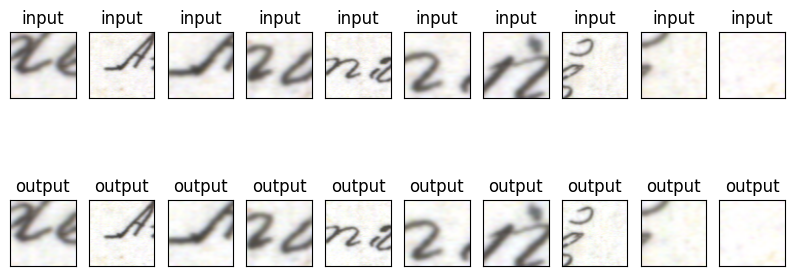

In [4]:

n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):

    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+6000]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+6000]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



In [16]:

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


class autoenc(Model):
    def __init__(self):
        super(autoenc, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64, 3)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same')])
            #layers.MaxPooling2D((2, 2), padding='same')])

        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = autoenc()
autoencoder.encoder.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
Total params: 370816 (1.41 MB)
Trainable params: 3708

In [17]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


start = time.time()
model = autoencoder.fit(train_input, train_output,
                epochs=epoch,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=16)

autoencoder.encoder.summary()


autoencoder.save(file_path + 'autoencoder_maxpooling_' + str(model_number) + '_whole')

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'loss_autoencoder_maxpooling_'+ str(model_number) + '_whole.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'val_loss_autoencoder_maxpooling_'+ str(model_number) + '_whole.csv')

# record end time
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")


Epoch 1/100
968/968 [==============================] - 30s 23ms/step - loss: 0.0048 - val_loss: 9.2463e-04
Epoch 2/100
968/968 [==============================] - 19s 20ms/step - loss: 6.4886e-04 - val_loss: 8.2458e-04
Epoch 3/100
968/968 [==============================] - 19s 20ms/step - loss: 5.3418e-04 - val_loss: 6.7071e-04
Epoch 4/100
968/968 [==============================] - 20s 20ms/step - loss: 5.0067e-04 - val_loss: 5.9523e-04
Epoch 5/100
968/968 [==============================] - 19s 20ms/step - loss: 4.6659e-04 - val_loss: 6.9477e-04
Epoch 6/100
968/968 [==============================] - 20s 20ms/step - loss: 4.3912e-04 - val_loss: 5.2301e-04
Epoch 7/100
968/968 [==============================] - 20s 20ms/step - loss: 4.2807e-04 - val_loss: 5.1738e-04
Epoch 8/100
968/968 [==============================] - 20s 21ms/step - loss: 4.1098e-04 - val_loss: 6.5854e-04
Epoch 9/100
968/968 [==============================] - 20s 21ms/step - loss: 4.0246e-04 - val_loss: 4.7770e-04
Epoch

In [ ]:

from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np

n_size = 64
def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data


#filename = str('[WB] 1885_Mactan_NAP_FelixPelayo.png')
#filename = str("1885_Mactan_NAP_FelixPelayo.tiff")
filename = str("[WB] 1872_Mindanao_NAP_D.FedericoCaballero.tif")
#filename = str("[WB] XXXX_Cagayan y Ilocos_online.png")
test = Image.open(file_path+ "Testing nbs/" + filename)
test = test.convert('RGB')
w_dirty, h_dirty = test.size


autoencoder = keras.models.load_model(file_path + 'unet_64')


xx = int(w_dirty/n_size)
final=[]

for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)

    neverbeforeseen = np.array(crop_(im1))
    #encoded_imgs = autoencoder.encoder(neverbeforeseen).numpy()
    decoded_imgs = autoencoder.predict(neverbeforeseen)

    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))

    #y = np.where(col > 0.5,1,0) #round the values
    y= col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

final = np.squeeze(final)
reconstructed = Image.fromarray(final)
reconstructed.save(file_path + "Testing nbs/"+"CLEAN_Unet64"+filename)

4/4 [==============================] - 0s 28ms/step
